<a href="https://colab.research.google.com/github/Hazuna227/221230039-Pengantar-ML/blob/main/project_week/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
zalando_research_fashionmnist_path = kagglehub.dataset_download('zalando-research/fashionmnist')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


In [ ]:
# Import Library
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVC, SVC

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical

In [ ]:
# Load dataset CSV (Kaggle path)
print("Library siap digunakan!")

# PATH KAGGLE (sesuaikan jika folder berbeda)
DATA_DIR = "/kaggle/input/fashionmnist"
TRAIN_PATH = os.path.join(DATA_DIR, "fashion-mnist_train.csv")
TEST_PATH  = os.path.join(DATA_DIR, "fashion-mnist_test.csv")

print("Sedang membaca file CSV...")

train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

print(f"Data Train Loaded: {train_df.shape}")
print(f"Data Test Loaded : {test_df.shape}")

train_df.head()

Library siap digunakan!
Sedang membaca file CSV...
Data Train Loaded: (60000, 785)
Data Test Loaded : (10000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Pisahkan fitur (pixel) dan label
# Kolom pertama adalah label, sisanya 784 pixel
X_train_raw = train_df.iloc[:, 1:].values.astype("float32")
y_train_raw = train_df.iloc[:, 0].values.astype("int")

X_test_raw  = test_df.iloc[:, 1:].values.astype("float32")
y_test      = test_df.iloc[:, 0].values.astype("int")

# Hapus dataframe untuk hemat RAM
del train_df
del test_df

print("X_train_raw:", X_train_raw.shape, "| y_train_raw:", y_train_raw.shape)
print("X_test_raw :", X_test_raw.shape,  "| y_test     :", y_test.shape)

X_train_raw: (60000, 784) | y_train_raw: (60000,)
X_test_raw : (10000, 784) | y_test     : (10000,)


In [ ]:
# Normalisasi pixel (0–255 → 0–1)
X_train_norm = X_train_raw / 255.0
X_test_norm  = X_test_raw / 255.0

print("Normalisasi selesai. Contoh nilai pixel:", X_train_norm[0][:10])

# Fungsi: Menstabilkan training model dengan membuat skala pixel menjadi 0–1.

Normalisasi selesai. Contoh nilai pixel: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# Split Train → Train + Validation
X_train_flat, X_val_flat, y_train, y_val = train_test_split(
    X_train_norm, y_train_raw,
    test_size=0.1,
    random_state=42,
    stratify=y_train_raw
)

print("Jumlah TRAIN:", X_train_flat.shape[0])
print("Jumlah VAL  :", X_val_flat.shape[0])
print("Jumlah TEST :", X_test_norm.shape[0])

Jumlah TRAIN: 54000
Jumlah VAL  : 6000
Jumlah TEST : 10000


In [ ]:
# Bentuk data untuk CNN (reshape 28x28x1)
X_train_cnn = X_train_flat.reshape(-1, 28, 28, 1)
X_val_cnn   = X_val_flat.reshape(-1, 28, 28, 1)
X_test_cnn  = X_test_norm.reshape(-1, 28, 28, 1)

print("Shape CNN TRAIN:", X_train_cnn.shape)
print("Shape CNN VAL  :", X_val_cnn.shape)
print("Shape CNN TEST :", X_test_cnn.shape)

# Fungsi: Mengubah bentuk input agar sesuai format CNN yaitu gambar 2D grayscale.

Shape CNN TRAIN: (54000, 28, 28, 1)
Shape CNN VAL  : (6000, 28, 28, 1)
Shape CNN TEST : (10000, 28, 28, 1)


In [ ]:
# One-hot encoding untuk MLP & CNN
y_train_cat = to_categorical(y_train, 10)
y_val_cat   = to_categorical(y_val, 10)
y_test_cat  = to_categorical(y_test, 10)

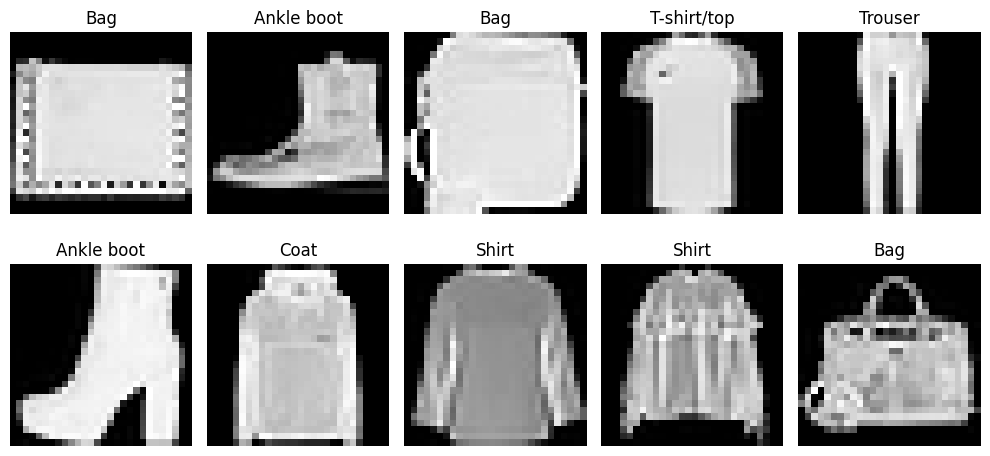

In [ ]:
# EDA
# Fungsi: Menampilkan contoh gambar 10 kelas untuk memastikan data benar.

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train_cnn[i].reshape(28, 28), cmap="gray")
    plt.title(class_names[np.argmax(y_train_cat[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()

# MODEL 1: SVM (Traditional ML)

In [ ]:
# StandardScaler untuk SVM
scaler_svm = StandardScaler()
X_train_svm = scaler_svm.fit_transform(X_train_flat)
X_val_svm   = scaler_svm.transform(X_val_flat)
X_test_svm  = scaler_svm.transform(X_test_norm)

In [ ]:
# SVM Linear
# print("\n--- Training SVM Linear (LinearSVC) ---")
# start = time.time()

# svm_linear = LinearSVC(random_state=42, max_iter=10000)
# svm_linear.fit(X_train_svm, y_train)

# y_pred_svm_linear = svm_linear.predict(X_test_svm)
# acc_svm_linear = accuracy_score(y_test, y_pred_svm_linear)

# print(f"Waktu Training: {time.time() - start:.2f} detik")
# print(f"Akurasi SVM Linear (TEST): {acc_svm_linear:.4f}")


--- Training SVM Linear (LinearSVC) ---
Waktu Training: 5485.77 detik
Akurasi SVM Linear (TEST): 0.8456


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
print("\n--- Training SVM RBF")
start = time.time()

limit = 10000  # supaya tidak lama
svm_rbf = SVC(kernel="rbf", C=10, gamma="scale")
svm_rbf.fit(X_train_svm[:limit], y_train[:limit])

y_pred_svm_rbf = svm_rbf.predict(X_test_svm)
acc_svm_rbf = accuracy_score(y_test, y_pred_svm_rbf)

print(f"Waktu Training: {time.time() - start:.2f} detik")
print(f"Akurasi SVM RBF (TEST): {acc_svm_rbf:.4f}")


--- Training SVM RBF (Opsional, lebih berat) ---
Waktu Training: 79.49 detik
Akurasi SVM RBF (TEST): 0.8749


In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score
# import time

# print("\n--- Training Random Forest ---")
# start = time.time()

# rf_model = RandomForestClassifier(
  #  n_estimators=200,
  #  random_state=42,
  #  n_jobs=-1
# )

# rf_model.fit(X_train_flat, y_train)

# y_pred_rf = rf_model.predict(X_test_norm)
# acc_rf = accuracy_score(y_test, y_pred_rf)

# print(f"Waktu Training: {time.time() - start:.2f} detik")
# print(f"Akurasi Random Forest (TEST): {acc_rf:.4f}")


--- Training Random Forest ---
Waktu Training: 85.68 detik
Akurasi Random Forest (TEST): 0.8837


# MODEL 2: MLP (Deep Learning)

In [ ]:
# Build MLP
# Fungsi: MLP mempelajari pola dari 784 pixel (flatten) dengan 4 hidden layer.
print("\n--- Training MLP ---")

model_mlp = Sequential([
    Dense(512, activation='relu', input_shape=(784,)),  # Input 784 pixel

    Dense(256, activation='relu'),                      # Hidden 1
    Dense(128, activation='relu'),                      # Hidden 2
    Dense(64, activation='relu'),                       # Hidden 3
    Dense(32, activation='relu'),                       # Hidden 4

    Dense(10, activation='softmax')                     # Output 10 kelas
])


model_mlp.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_mlp.summary()


--- Training MLP ---


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 576,810 (2.20 MB)

 Trainable params: 576,810 (2.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train MLP
# Fungsi: Training MLP menggunakan data train dan memantau performa menggunakan data validation.

history_mlp = model_mlp.fit(
    X_train_flat, y_train_cat,
    validation_data=(X_val_flat, y_val_cat),
    epochs=15,
    batch_size=128,
    verbose=1
)

loss_mlp, acc_mlp = model_mlp.evaluate(X_test_norm, y_test_cat, verbose=0)
print(f"Akurasi MLP (TEST): {acc_mlp:.4f}")

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7350 - loss: 0.7506 - val_accuracy: 0.8538 - val_loss: 0.3994
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8590 - loss: 0.3851 - val_accuracy: 0.8617 - val_loss: 0.3759
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8741 - loss: 0.3443 - val_accuracy: 0.8733 - val_loss: 0.3601
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8867 - loss: 0.3121 - val_accuracy: 0.8778 - val_loss: 0.3289
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8914 - loss: 0.2900 - val_accuracy: 0.8777 - val_loss: 0.3380
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8957 - loss: 0.2799 - val_accuracy: 0.8737 - val_loss: 0.3429
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8997 - loss: 0.2698 - val_accuracy: 0.8710 - val_loss: 0.3534
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9048 - loss: 0.2579 - val_accur

# MODEL 3: CNN (Deep Learning)

In [ ]:
print("\n--- Training CNN (3 Conv Layers) ---")

model_cnn = Sequential([
    # Conv Layer 1
    Conv2D(32, (3,3), activation="relu", input_shape=(28,28,1)),
    MaxPooling2D((2,2)),

    # Conv Layer 2
    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D((2,2)),

    # Flatten & Dense
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(10, activation="softmax")
])

model_cnn.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_cnn.summary()


--- Training CNN (3 Conv Layers) ---


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train CNN
# Fungsi: Training CNN pada train set dan memantau overfitting lewat validation set.
history_cnn = model_cnn.fit(
    X_train_cnn, y_train_cat,
    validation_data=(X_val_cnn, y_val_cat),
    epochs=10,
    batch_size=128,
    verbose=1
)

loss_cnn, acc_cnn = model_cnn.evaluate(X_test_cnn, y_test_cat, verbose=0)
print(f"Akurasi CNN (TEST): {acc_cnn:.4f}")

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.6881 - loss: 0.8672 - val_accuracy: 0.8443 - val_loss: 0.4178
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.8490 - loss: 0.4076 - val_accuracy: 0.8705 - val_loss: 0.3512
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step - accuracy: 0.8753 - loss: 0.3456 - val_accuracy: 0.8883 - val_loss: 0.3071
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.8889 - loss: 0.3058 - val_accuracy: 0.8947 - val_loss: 0.2892
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 22s 52ms/step - accuracy: 0.8969 - loss: 0.2793 - val_accuracy: 0.8945 - val_loss: 0.2797
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 22s 52ms/step - accuracy: 0.9018 - loss: 0.2691 - val_accuracy: 0.9045 - val_loss: 0.2648
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 22s 52ms/step - accuracy: 0.9093 - loss: 0.2447 - val_accuracy: 0.9053 - val_loss: 0.2593
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9130 - loss: 0.2333 - 

# PERBANDINGAN + LEARNING CURVE

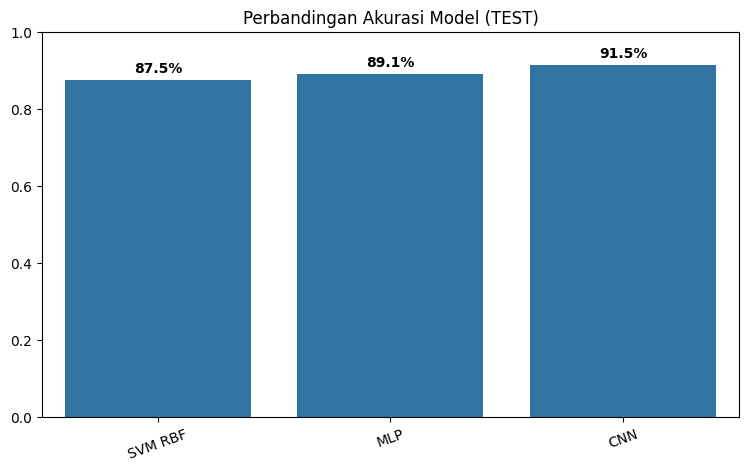

In [ ]:
# Grafik perbandingan akurasi model
results = {
    "SVM RBF": acc_svm_rbf,
    "MLP": acc_mlp,
    "CNN": acc_cnn
}

plt.figure(figsize=(9,5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Perbandingan Akurasi Model (TEST)")
plt.ylim(0, 1.0)
plt.xticks(rotation=20)

for i, v in enumerate(list(results.values())):
    plt.text(i, v + 0.02, f"{v*100:.1f}%", ha="center", fontweight="bold")

plt.show()

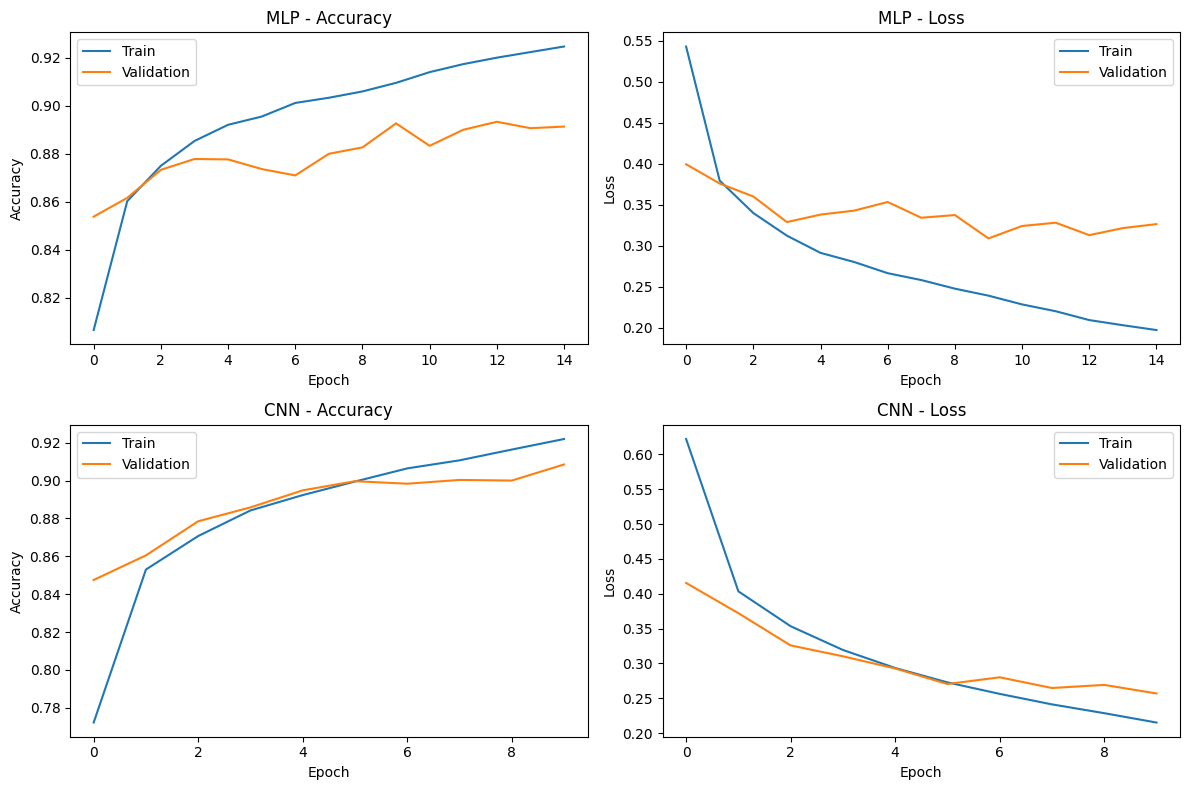

In [ ]:
# Learning curve MLP & CNN

plt.figure(figsize=(12,8))

# 1) MLP Accuracy
plt.subplot(2, 2, 1)
plt.plot(history_mlp.history["accuracy"], label="Train")
plt.plot(history_mlp.history["val_accuracy"], label="Validation")
plt.title("MLP - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# 2) MLP Loss
plt.subplot(2, 2, 2)
plt.plot(history_mlp.history["loss"], label="Train")
plt.plot(history_mlp.history["val_loss"], label="Validation")
plt.title("MLP - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# 3) CNN Accuracy
plt.subplot(2, 2, 3)
plt.plot(history_cnn.history["accuracy"], label="Train")
plt.plot(history_cnn.history["val_accuracy"], label="Validation")
plt.title("CNN - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# 4) CNN Loss
plt.subplot(2, 2, 4)
plt.plot(history_cnn.history["loss"], label="Train")
plt.plot(history_cnn.history["val_loss"], label="Validation")
plt.title("CNN - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# CONFUSION MATRIX MODEL TERBAIK
best_model_name = max(results, key=results.get)
print("Model terbaik:", best_model_name)

Model terbaik: CNN


In [ ]:
# Prediksi sesuai model terbaik
if best_model_name == "SVM RBF":
    y_best_pred = y_pred_svm_rbf

elif best_model_name == "MLP":
    y_prob = model_mlp.predict(X_test_norm)
    y_best_pred = np.argmax(y_prob, axis=1)

else:  # CNN
    y_prob = model_cnn.predict(X_test_cnn)
    y_best_pred = np.argmax(y_prob, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


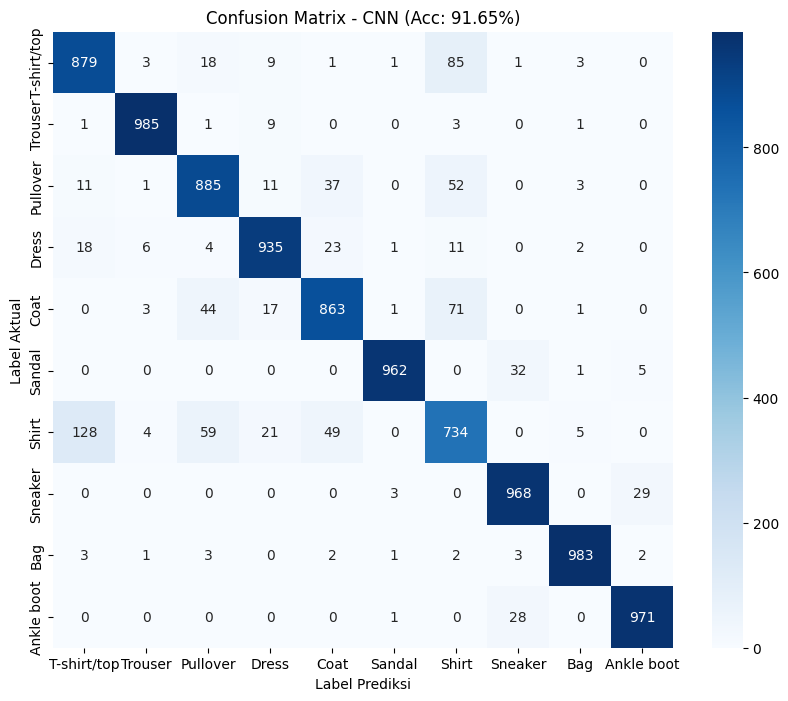


Classification Report (Model Terbaik):
              precision    recall  f1-score   support

 T-shirt/top       0.85      0.88      0.86      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.87      0.89      0.88      1000
       Dress       0.93      0.94      0.93      1000
        Coat       0.89      0.86      0.87      1000
      Sandal       0.99      0.96      0.98      1000
       Shirt       0.77      0.73      0.75      1000
     Sneaker       0.94      0.97      0.95      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.96      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [ ]:
# Confusion matrix + classification report
cm = confusion_matrix(y_test, y_best_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title(f"Confusion Matrix - {best_model_name} (Acc: {results[best_model_name]*100:.2f}%)")
plt.ylabel("Label Aktual")
plt.xlabel("Label Prediksi")
plt.show()

print("\nClassification Report (Model Terbaik):")
print(classification_report(y_test, y_best_pred, target_names=class_names))
